# <font color='darkblue'>대회 소개</font>

### TGS Salt Identification Challenge
**Segment salt deposits beneath the Earth's surface**  
https://www.kaggle.com/c/tgs-salt-identification-challenge/overview

---

***Description***

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

---

## <font color='blue'>라이브러리 가져오기</font>

In [ ]:
import numpy as np 
import pandas as pd 
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, Conv2DTranspose
from keras import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

---

## <font color='blue'>데이터 불러오기</font>

In [3]:
with zipfile.ZipFile('../input/tgs-salt-identification-challenge/train.zip', 'r') as z : 
    z.extractall('train')
    
with zipfile.ZipFile('../input/tgs-salt-identification-challenge/test.zip', 'r') as z : 
    z.extractall('test')

In [37]:
train = pd.read_csv('../input/tgs-salt-identification-challenge/train.csv')
depth = pd.read_csv('../input/tgs-salt-identification-challenge/depths.csv')
train

id                                           rle_mask
0     575d24d81d                                                NaN
1     a266a2a9df                                          5051 5151
2     75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3     34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4     4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
...          ...                                                ...
3995  9cbd5ddba4                                                NaN
3996  caa039b231  2398 7 2499 11 2600 16 2700 22 2801 26 2901 29...
3997  1306fcee4c                                                NaN
3998  48d81e93d9  2828 1 2927 3 3026 5 3126 6 3225 8 3324 10 342...
3999  edf1e6ac00                                                NaN

[4000 rows x 2 columns]

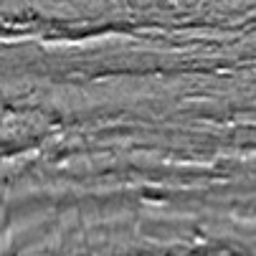

In [38]:
images= glob.glob('./train/images/*')
masks= glob.glob('./train/masks/*')

Image.open(images[2]).resize((256,256))

---

## <font color='blue'>이미지(원본 및 마스크) 확인하기</font>

In [6]:
images_df = pd.DataFrame({'images' : images,
                         'masks' : masks})
images_df

images                         masks
0     ./train/images/97970b5e2c.png  ./train/masks/97970b5e2c.png
1     ./train/images/96f26f6397.png  ./train/masks/96f26f6397.png
2     ./train/images/1ab49f29e9.png  ./train/masks/1ab49f29e9.png
3     ./train/images/cef624f327.png  ./train/masks/cef624f327.png
4     ./train/images/1d2cd614be.png  ./train/masks/1d2cd614be.png
...                             ...                           ...
3995  ./train/images/b6c52b4a53.png  ./train/masks/b6c52b4a53.png
3996  ./train/images/8a58fe70f8.png  ./train/masks/8a58fe70f8.png
3997  ./train/images/89562d9f7d.png  ./train/masks/89562d9f7d.png
3998  ./train/images/f870e41e88.png  ./train/masks/f870e41e88.png
3999  ./train/images/2bce09096c.png  ./train/masks/2bce09096c.png

[4000 rows x 2 columns]

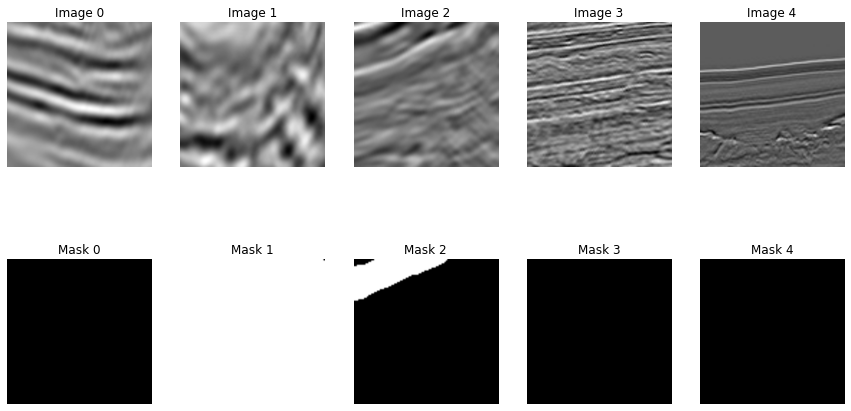

In [7]:
fig , axes = plt.subplots(2,5)
fig.set_size_inches(15,8)

for index in range(0,5):
    idx = random.randrange(len(images_df))
    img = Image.fromarray(cv2.imread(images_df.iloc[idx,0], cv2.IMREAD_COLOR)).resize((256,256))
    mask = Image.fromarray(cv2.imread(images_df.iloc[idx,1], cv2.IMREAD_COLOR)).resize((256,256))

    axes[index//5 , index%5].imshow(img)
    axes[index//5 , index%5].set_title(f'Image {index}')
    axes[index//5,  index%5].axis('off')
    
    axes[index//5+1 , index%5].imshow(mask)
    axes[index//5+1 , index%5].set_title(f'Mask {index}')
    axes[index//5+1,  index%5].axis('off')    

---

## <font color='blue'>데이터 전처리</font>

* `segmentation` 대회의 정답값은 예전 `classification` 대회처럼 클라스 값이 아니라 이미지이다.
* Input image에서 소금인 영역을 찾아내야 한다.
* 따라서 예전처럼 `ImageDataGenerator`로 데이터를 처리하기 까다롭기 때문에 직접 데이터셋을 `customizing` 해보자.


* `segmentation` 에서는 `UNet` 모델을 가장 많이 사용한다. 
    * 모델을 직접 쌓아보면 알겠지만 이미지의 사이즈가 2의 거듭제곱 형태이면 편하다.
    * U 형태로 feature extraction이 이루어지고, 밑으로 갈수록 이미지의 크기는 작아지지만 채널 수가 늘어나는 특징이 있다.
    * 이진분류, 다중분류 등에 사용된다.

### <font color='green'>Train Dataset 전처리하기</font>

* 대부분 `ImageDataGenerator`로 이미지 전처리가 가능하지만, 몇몇 대회에선 이미지 형태에 따라 전처리를 직접 해야하는 경우가 있다. 어떤한 데이터 형태든 다룰 수 있도록 직접 전처리 하는 방법들을 익혀두자.


* 먼저 데이터를 담을 빈 그릇을 만든다.
    * 빈 그릇을 만들 때 너비, 높이 뿐만 아니라 채널을 잊지 말고 설정해주자.
    * 이미지의 RGB 픽셀 값들을 보면 모두 같음을 알수 있다. 학습 속도 향상을 위해 하나의 채널만 사용하자.
    * image 데이터 타입은 가장 효율적으로 정보를 담을 수 있는 `dtype = np.uint8`으로 설정한다. 
        * 양수만 표현 가능하다.
        * 2^8 개수 만큼 표현 가능하다.(0 ~ 255)
    * y 데이터 타입은 `dtype = np.bool`로 설정한다.

In [8]:
# All the values are same
np.array(Image.open(images[0]))[:,:,0]
np.array(Image.open(images[0]))[:,:,1]
np.array(Image.open(images[0]))[:,:,2]

array([[104, 103, 103, ..., 121, 130, 134],
       [110,  89,  77, ..., 133, 135, 134],
       [121,  97,  77, ..., 141, 136, 134],
       ...,
       [162, 155, 162, ..., 142, 142, 140],
       [170, 160, 158, ..., 144, 143, 141],
       [170, 159, 154, ..., 144, 143, 141]], dtype=uint8)

#### <font color='purple'>빈 그릇 만들기</font>

In [39]:
train = np.zeros((4000,128,128,1), dtype = np.uint8)
y = np.zeros((4000,128,128,1), dtype = np.bool)

#### <font color='purple'>이미지 데이터 담기</font>

In [40]:
for i,j in tqdm_notebook(enumerate(images), total=4000):
    image = load_img(j)
    image = img_to_array(image)[:,:,0] # 한 채널값만 사용하기
    image = resize(image,(128,128,1))  # (101,101,1) -> (128,128,1)
    train[i] = image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


#### <font color='purple'>Mask 데이터 담기</font>

* Mask 데이터는 True, False 형태로 픽셀값이 채워져야 한다.

In [41]:
for i,j in tqdm_notebook(enumerate(masks), total = 4000):
    mask = load_img(j)
    mask = img_to_array(mask)[:,:,0]
    y[i] = resize(mask, (128,128,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


---

## <font color='blue'>Train, Valid 나누기</font>

* `segmentation`은 회귀 문제의 느낌이 있다.
* 이미지마다 소금이 들어있는 정도가 다를 수 있으므로, 회귀에서 `y`의 비율을 맞추려면 어떻게 해야할까.
    * 소금의 비율 구간을 나눈다.
    * 구간별로 추출하면 안정적인 평가 셋이 될 것이다.
    * 지금은 우선 `train_test_split`으로 일괄적으로 나누자.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train,y, test_size = 0.1, random_state = 42) 

---

## <font color='blue'>U-net 모델 구축하기</font>

* Classification 문제에선 주로 `model = Sequential()` 을 사용한 비교적 단순한 모델 구조를 쌓았다.
* 함수를 이용하여 층들을 병렬로 쌓을 수 있는 방법을 적용하자. `Functional API` 라고도 부른다.

* U-net 모델 구조의 특징
    * 출력값의 크기는 Input의 크기와 같다.
        * 이미지 분류 문제에서는 이미지의 크기가 작아지다가 Dense층을 거쳐 확률값으로 나가는 형태인데, Segmentation 문제에서는 input과 output이 똑같은 크기를 갖는다.
    * 각각의 픽셀값이 [0,1] 사이로 출력 되어야 한다.

### <font color='green'>가장 단순한 U-net 구조</font>

* UNet에서는 padding 옵션 넣어 이미지의 크기가 줄어드는 것을 방지한다. 기본값인 `valid`이면 이미지 크기가 작아진다.
* 0~1 사이로 값이 나가야하므로 출력층에서 `sigmoid`를 적용한다.
* 모델을 선언할 때 `input`, `output`을 명시해준다.

In [13]:
inp = Input((128,128,1))
cnn1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inp)
out = Conv2D(1, (1,1), activation = 'sigmoid')(cnn1)
model = Model(inp, out) 

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 1)       17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


### <font color='green'>U-net 구조 응용하기</font>

* `Conv2DTranspose()` 층은 줄어든 이미지를 다시 키우기 위한 연산 작업이다. **비선형 학습**이 이루어지지 않기 때문에 `activation`함수를 설정해주지 않는다. 

* `concatenate` 를 통해 사이즈가 같은 층끼리 합쳐준다. 기본적으로 `axis=-1`로 설정되어 있어 마지막 축을 기준으로 합쳐진다.
* 아직은 U-net 구조를 깊게 쌓지 않아서 모델의 성능이 높게 나오진 않는다. 다른 하이퍼파라미터 최적화를 끝낸 후, 모델을 더 깊게 쌓아보자.

In [43]:
inp = Input((128,128,1))

cnn0 = Conv2D(8, (3,3), activation = 'relu', padding='same')(inp)
cnn0 = Conv2D(8, (3,3), activation = 'relu', padding='same')(cnn0)
pool0 = MaxPooling2D()(cnn0) 

cnn1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(pool0)
cnn1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(cnn1)
pool1 = MaxPooling2D()(cnn1) 

cnn2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool1)
cnn2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(cnn2)
pool2 = MaxPooling2D()(cnn2)

cnn3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool2)
cnn3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(cnn3)
pool3 = MaxPooling2D()(cnn3)

cnn_m = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool3)


# 이미지 크기 키우기
ct3 = Conv2DTranspose(64, (3,3), padding='same', strides = (2,2))(cnn_m)
cc3 = concatenate([ct3, cnn3])
cc3_up = Conv2D(64, (3,3), activation = 'relu', padding='same')(cc3)
cc3_up = Conv2D(64, (3,3), activation = 'relu', padding='same')(cc3_up)

ct2 = Conv2DTranspose(32, (3,3),padding='same', strides = (2,2))(cc3_up) 
cc2 = concatenate([ct2, cnn2])
cc2_up = Conv2D(32, (3,3),activation = 'relu', padding='same')(cc2) 
cc2_up = Conv2D(32, (3,3),activation = 'relu', padding='same')(cc2_up)


ct1 = Conv2DTranspose(16, (3,3), padding='same', strides = (2,2))(cc2_up)
cc1 = concatenate([ct1, cnn1]) 
cc1_up = Conv2D(16, (3,3), activation='relu', padding='same')(cc1) 
cc1_up = Conv2D(16, (3,3), activation='relu', padding='same')(cc1_up)

ct0 = Conv2DTranspose(8, (3,3), padding='same', strides = (2,2))(cc1_up)
cc0 = concatenate([ct0, cnn0]) 
cc0_up = Conv2D(8, (3,3), activation='relu', padding='same')(cc0) 
cc0_up = Conv2D(8, (3,3), activation='relu', padding='same')(cc0_up)

out = Conv2D(1, (1,1), activation = 'sigmoid')(cc0_up) 

model = Model(inp, out)
model.summary()
# val_loss = 0.1921 

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 8)  584         conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_21[0][0]                  
_______________________________________________________________________________________

In [15]:
checkpoint = ModelCheckpoint('best.h5',save_best_only=True,verbose = True)
early_stop = EarlyStopping(patience=10, verbose=True)
reduce_lr = ReduceLROnPlateau(patience=6, verbose=True)

In [ ]:
model.compile(metrics = ['acc'], optimizer = 'adam', loss = 'binary_crossentropy')

model.fit(X_train,y_train, validation_data = (X_valid,y_valid), epochs = 5, callbacks=[checkpoint, early_stop, reduce_lr])

model.load_weights('best.h5')

Epoch 1/5
112/113 [============================>.] - ETA: 0s - loss: 0.1644 - acc: 0.9396
Epoch 00001: val_loss improved from 0.23510 to 0.22475, saving model to best.h5
113/113 [==============================] - 4s 31ms/step - loss: 0.1641 - acc: 0.9398 - val_loss: 0.2247 - val_acc: 0.9083
Epoch 2/5
112/113 [============================>.] - ETA: 0s - loss: 0.1596 - acc: 0.9423
Epoch 00002: val_loss did not improve from 0.22475
113/113 [==============================] - 3s 27ms/step - loss: 0.1594 - acc: 0.9424 - val_loss: 0.2567 - val_acc: 0.9115
Epoch 3/5
111/113 [============================>.] - ETA: 0s - loss: 0.1501 - acc: 0.9450
Epoch 00003: val_loss did not improve from 0.22475
113/113 [==============================] - 3s 27ms/step - loss: 0.1493 - acc: 0.9452 - val_loss: 0.2593 - val_acc: 0.9141
Epoch 4/5
112/113 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9443
Epoch 00004: val_loss did not improve from 0.22475
113/113 [==============================] 

---

## <font color='blue'>Validation Data를 ***Mean IOU***로 평가하기</font>


* 대회 점수를 올리기 위해 다음의 과정을 거치게 된다. 
    * (1) 현재의 모델을 최적화하기
    * (2) 모델의 구조를 복잡하게 하기
    

* 먼저 주어진 모델을 최적화한 다음 모델 구조를 복잡하게 해야 최소한의 노력, 시간으로 효율적으로 모델 성능을 높일 수 있다.


* Test 데이터셋을 예측하기 전, 이 대회의 평가 지표인 `Mean IOU`로 모델의 성능을 최적화 해보자.


### <font color ='green'>Validation Dataset 크기 조정하기</font>

In [17]:
result_valid = model.predict(X_valid, verbose=True)
print(result_valid.shape,y_valid.shape)

13/13 [==============================] - 0s 9ms/step
(400, 128, 128, 1) (400, 128, 128, 1)


* `Mean IOU` 채점 방식 역시 101x101 기준으로 이루어지기 때문에, 이와 같은 조건으로 설정해야 한다.
* result_valid 및 y_valid의 크기를 바꿔주자.

In [18]:
result_valid = np.squeeze(result_valid, axis = -1)
y_valid = np.squeeze(y_valid, axis = -1)

print(result_valid.shape, y_valid.shape)

(400, 128, 128) (400, 128, 128)


In [19]:
result_valid = np.array([resize(x,(101,101)) for x in result_valid])
y_valid = np.array([resize(x,(101,101)) for x in y_valid])

print(result_valid.shape, y_valid.shape)

(400, 101, 101) (400, 101, 101)


### <font color ='green'>Mean IOU 계산하기</font>


* validation dataset을 이용해 어떤 `threshold` 값이 높은 mean IOU 값을 갖는지 확인하자. 적절한 `threshold`를 찾아 Test Dataset 예측에 적용한다.


* `threshold` 값을 높게 잡으면 보수적으로 예측하게 되어 실제 환자를 건강하다고 예측하는 경우가 발생한다.
* 따라서 의료계에서는 보통 `threshold`을 낮게 잡는다.


* `np.linspace(0,1,num)` 함수를 이용하여 0~1 사이를 num개의 간격으로 나누자.

In [20]:
# mean IOU 함수 정의
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in # 실제 정답값
    y_pred = y_pred_in # 예측값
    
    true_objects = 2 # 소금 / not 소금  
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0] # 정답값과 비교

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in): # 0 또는 1로 들어감
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [21]:
thresholds = np.linspace(0,1,50)
thresholds

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [22]:
ious = np.array([iou_metric_batch(y_valid,np.round(result_valid > x)) for x in tqdm_notebook(thresholds)])
ious

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


array([0.515  , 0.40925, 0.414  , 0.421  , 0.43075, 0.41725, 0.4325 ,
       0.44375, 0.47325, 0.48925, 0.50425, 0.5195 , 0.5385 , 0.54375,
       0.55425, 0.56025, 0.58175, 0.596  , 0.60225, 0.62125, 0.62525,
       0.6425 , 0.644  , 0.64875, 0.65225, 0.6535 , 0.6555 , 0.66   ,
       0.667  , 0.66575, 0.66425, 0.67575, 0.679  , 0.68125, 0.67875,
       0.67575, 0.67825, 0.67675, 0.6765 , 0.67675, 0.6725 , 0.6655 ,
       0.6605 , 0.662  , 0.65125, 0.64975, 0.62825, 0.5985 , 0.567  ,
       0.52125])

### <font color ='green'>최적의 threshold 값 찾기</font>

* threshold 별로 계산된 IOU 값을 시각화해보자.
* 최적의 threshold 값을 `threshold_best`에 저장하여 test data 예측에 사용한다.
* 실제 제출 점수와 최적의 IOU 값이 비슷해야 모델이 안정적으로 학습된 것이다.

In [23]:
threshold_best_index = np.argmax(ious)
threshold_best_index

33

In [24]:
iou_best = ious[threshold_best_index]
iou_best

0.68125

In [25]:
threshold_best = thresholds[threshold_best_index]
threshold_best

0.673469387755102

Text(0, 0.5, 'iou')

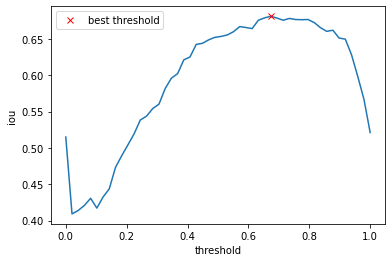

In [26]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label = 'best threshold')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('iou')

---

## <font color='blue'>Test data 예측하기</font>
* Train data를 구축했던 것처럼 Test data 역시 같은 방식으로 전처리 해주자.
* `model.predict()` 후 원래 이미지 크기인 `101x101`로 resize 해줘야 한다.
* 또한 `np.squeeze()`를 사용하여 마지막 차원을 제거해준다. 이미지의 차원도 다시 맞춰줘야 한다. 

In [27]:
test_image = glob.glob('./test/*/*')

test = np.zeros((len(test_image),128,128,1),dtype = np.uint8 )

for i,j in tqdm_notebook(enumerate(test_image), total=len(test_image)):
    img = load_img(j)
    img = img_to_array(img)[:,:,0]
    img = resize(img, (128,128,1))
    test[i] = img

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [28]:
result = model.predict(test)
print(result.shape)
result

(18000, 128, 128, 1)


array([[[[5.76892912e-01],
         [6.88284993e-01],
         [8.03465247e-01],
         ...,
         [1.50473267e-02],
         [2.73676906e-02],
         [7.13663921e-02]],

        [[7.82405853e-01],
         [6.43525422e-01],
         [7.39144981e-01],
         ...,
         [1.36808660e-02],
         [3.54402140e-02],
         [5.56613430e-02]],

        [[7.25231111e-01],
         [8.35377038e-01],
         [8.20990622e-01],
         ...,
         [6.79946318e-03],
         [1.67812742e-02],
         [4.86029610e-02]],

        ...,

        [[7.41204977e-01],
         [8.49960029e-01],
         [8.37216496e-01],
         ...,
         [8.78415287e-01],
         [9.30182278e-01],
         [8.56733441e-01]],

        [[8.24242830e-01],
         [9.56443906e-01],
         [8.82943213e-01],
         ...,
         [9.60310519e-01],
         [9.42029536e-01],
         [8.72903228e-01]],

        [[6.57357812e-01],
         [7.31150210e-01],
         [8.76976371e-01],
         ...,
 

In [29]:
from tqdm import tnrange
result_list = []

for i in tnrange(len(result)):
    resized_img = resize(np.squeeze(result[i]),(101,101)) 
    result_list.append(resized_img)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


---

## <font color = 'blue'>Submission 완료하기</font>


* `segmentation` 대회에서는 보통 각 픽셀별로 확률값 자체를 제출하지 않는다. 지금 이 대회만 보더라도 이미지 하나에 101x101 = 10201개의 픽셀이 존자하고, 총 18000개의 테스트 이미지로 183618000 개의 확률값이 나오게 된다. 이 값들을 그대로 재출 시 엄청난 양의 연산이 채점에 필요하게 될 것이므로, kaggle 측에서는 보통 대회와는 조금 다른 제출 방식을 요구하고 있다.


* `run-length encoding` 로 픽셀 값들을 바꿔준 뒤 제출을 해야 자신의 점수를 제대로 확인할 수 있다. 
    * **(1)** 기본적으로 `0.5`보다 확률값이 높으면 1, 아니면 0으로 바꿔주자.
        * `0.5` 역시 하이퍼파라미터로, 최적의 값을 찾아줘야 한다.
    * **(2)** 픽셀 값들을 `run-length encoding`로 바꿔준다. 1의 시작점과 시작점부터 **run-length**의 값이 한 쌍이 된다. 
        * 예를 들어, 000111001111 의 픽셀 값은 `3 3 8 4`로 표현된다.
   

### <font color ='green'> Run-Length Encoding 함수</font>

* run-length encoding 함수를 정의하고, 추출된 예측값을 dictionary 형태로 저장한다. 
* dictionary로 저장시, key값은 test image의 주소, value 값은 run-length 인코딩된 값이다.

In [30]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask(소금), 0 - background(소금X)
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F', )                  # 101 X 101 Flatten in column-major (Fortran- style) order
    pixels = np.concatenate([[0], pixels, [0]])         # 양 끝 zero padding
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]                             # [1::2] : index 1 부터 끝까지 두 칸 간격으로
    
    return ' '.join(str(x) for x in runs)               # 띄어쓰기 기준으로 나눔

In [31]:
result_dict = {x : rle_encode(np.round(result_list[i] > threshold_best))  for i,x in enumerate(tqdm_notebook(test_image))}
print(result_dict)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



{'./test/images/41a8ca9668.png': '2 8281 8285 99 8387 98 8490 96 8592 95 8695 93 8797 92 8900 90 9002 89 9106 86 9209 84 9311 83 9413 1 9415 80 9515 81 9618 1 9620 77 9723 75 9825 74 9925 75 10030 71 10132 70', './test/images/60b574ccdd.png': '3636 1 3734 4 3831 8 3931 9 4031 10 4129 13 4229 14 4329 15 4429 16 4528 18 4627 20 4727 21 4826 23 4926 24 5028 23 5129 23 5230 23 5332 22 5432 1 5434 21 5534 22 5635 22 5738 20 5841 18 5943 17 6044 17 6147 15 6251 12 6352 12 6455 10 6557 9 6659 8 6762 6 6865 4 6968 2 7170 2', './test/images/bc2160ec16.png': '93 9 193 10 293 11 393 12 494 12 594 13 695 13 796 13 896 14 996 15 1097 15 1197 16 1298 16 1398 17 1499 17 1599 18 1700 18 1800 19 1900 20 2001 20 2101 21 2201 22 2301 23 2402 23 2502 24 2602 25 2703 25 2803 26 2903 27 3003 28 3103 29 3202 31 3303 31 3403 32 3503 33 3603 34 3703 35 3803 36 3903 37 4003 38 4103 39 4203 40 4303 41 4403 42 4504 42 4604 43 4704 44 4804 45 4904 46 5005 46 5106 46 5207 46 5307 47 5408 47 5509 47 5609 48 5710 48

### <font color = 'green'>최종 제출</font>


* 기존의 제출 형식(칼럼 이름, 각 칼럼에 들어가는 값)을 확인하자.
* Dictionary 형태로 만들어둔 result 값을 제출 형식에 맞게 변형한다.

In [32]:
sub = pd.read_csv('/kaggle/input/tgs-salt-identification-challenge/sample_submission.csv')
sub

id rle_mask
0      155410d6fa      1 1
1      78b32781d1      1 1
2      63db2a476a      1 1
3      17bfcdb967      1 1
4      7ea0fd3c88      1 1
...           ...      ...
17995  c78063e0a6      1 1
17996  bfcdcd2720      1 1
17997  07c3553ef7      1 1
17998  9c2e45bf79      1 1
17999  41d0f0703c      1 1

[18000 rows x 2 columns]

In [33]:
sub_df = pd.DataFrame.from_dict(result_dict,orient = 'index') # if the keys should be rows, pass 'index'
sub_df = sub_df.reset_index()
sub_df = sub_df.rename(columns={'index': 'id',0:'rle_mask'}) # rename column names
sub_df['id']  = sub_df['id'].apply(lambda x : x.split('/')[-1].split('.')[0])
sub_df

id                                           rle_mask
0      41a8ca9668  2 8281 8285 99 8387 98 8490 96 8592 95 8695 93...
1      60b574ccdd  3636 1 3734 4 3831 8 3931 9 4031 10 4129 13 42...
2      bc2160ec16  93 9 193 10 293 11 393 12 494 12 594 13 695 13...
3      a3b91acb96                                                   
4      9a4222ba49  1 3230 3233 96 3334 95 3435 93 3536 90 3637 86...
...           ...                                                ...
17995  810309305f                                                   
17996  46a88e46a1                                                   
17997  eb3b019e86  25 4 30 69 100 1 126 77 227 77 328 77 429 77 5...
17998  cc9a95b13f  1 606 612 96 715 94 818 92 920 6 927 84 1023 1...
17999  a06546807e                                                   

[18000 rows x 2 columns]

In [34]:
sub_df.to_csv('sub_segmentation.csv',index=False)